## VQA : Answer questions over a picture

Inspired and partially taken from [https://github.com/mdda/deep-learning-workshop/blob/master/notebooks/work-in-progress/2018-08_DidTheModelUnderstandTheQuestion/VQA_playground.ipynb](https://github.com/mdda/deep-learning-workshop/blob/master/notebooks/work-in-progress/2018-08_DidTheModelUnderstandTheQuestion/VQA_playground.ipynb)

#### To answer a question

*  Convert the image to features 
*  Convert the question to a vector
*  Pass both into the the VQA model
*  Interpret the answer vectors and extract the answer in descending orders of relevance

In [1]:
# Upgrade pillow to latest version (solves a colab Issue) :
#!pip3 install -U Pillow

In [1]:
import os, sys

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Cleaner demos : Don't do this normally...

### Download the Prebuilt VQA model and Weights

In [2]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

Cloning into 'pytorch-vqa'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 47 (delta 1), reused 1 (delta 0), pack-reused 40
Receiving objects: 100% (47/47), 23.06 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [9]:
# https://github.com/Cyanogenoid/pytorch-vqa/releases

#windows

if not os.path.isfile('./data/2017-08-04_00.55.19.pth'):   # 81Mb model
    !wget https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

/bin/bash: wget: command not found


In [4]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
import model # from pytorch-vqa

#saved_state = torch.load('logs/2017-08-04_00:55:19.pth')
saved_state = torch.load('./data/2017-08-04_00.55.19.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1

#saved_state.keys()  # See what's in the saved state

In [12]:
# Load the predefined model
vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

### Now get the Correct Image feature network

In [24]:
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

In [25]:
import resnet  # from pytorch-resnet

import torchvision.transforms as transforms
from PIL import Image

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Scale(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 448  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        #print(img_transformed.size())
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /Users/davebrunner/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth
100%|██████████| 230M/230M [00:18<00:00, 12.9MB/s]


In [26]:
# Sample images : 
image_urls, image_path, image_files = [
    'https://imgc.allpostersimages.com/img/print/posters/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
    'https://i.ytimg.com/vi/AIwlyly7Eso/hqdefault.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/9/9b/Black_pussy_-_panoramio.jpg',
    'https://www.thehappycatsite.com/wp-content/uploads/2017/06/siamese5.jpg',
    'https://c.pxhere.com/photos/15/e5/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg!d',
], './data/img/', []
os.makedirs('./data/img', exist_ok=True)


image_urls[4] = 'https://c.pxhere.com/photos/15/e5/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg'


for url in image_urls:
    image_file=os.path.join(image_path, os.path.basename(url))
    image_files.append(image_file)
    if not os.path.isfile(image_file):
        !wget {url} --directory-prefix ./img/
image_files



['./data/img/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
 './data/img/hqdefault.jpg',
 './data/img/Black_pussy_-_panoramio.jpg',
 './data/img/siamese5.jpg',
 './data/img/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg']

In [27]:
v = resnet_layer4.image_to_features(image_files[1])
#v.size()

In [28]:
vocab = saved_state['vocab']
#vocab.keys()  # dict_keys(['question', 'answer'])
#list(vocab['question'].items())[:5]  # [('the', 1), ('is', 2), ('what', 3), ('are', 4), ('this', 5)]

In [29]:
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    #vec = torch.zeros(QUESTION_LENGTH_MAX).long()
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [30]:
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w

In [31]:
#all the possible answers
len(answer_words), answer_words[1:20]  # 3000, ['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green']"

(3000,
 ['no',
  '2',
  '1',
  'white',
  '3',
  'red',
  'blue',
  '4',
  'green',
  'black',
  'yellow',
  'brown',
  '5',
  'tennis',
  'baseball',
  '6',
  'orange',
  '0',
  'bathroom'])

### Let's test a single Image

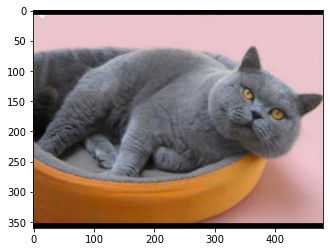

In [32]:
image_idx = 1
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

In [33]:
v0 = resnet_layer4.image_to_features(image_filename)

In [34]:
q, q_len = encode_question("is there a cat in the picture")
#q, q_len = encode_question("what color is the cat's fur")
#q, q_len = encode_question("is the cat jumping up or down")
#q, q_len

In [35]:
ans = vqa_net(v0, q.unsqueeze(0), q_len.unsqueeze(0))
ans.data.cpu()[0:10]

tensor([[ -3.2231,  -3.6883,  -9.6714,  ..., -26.1402, -25.1174, -22.7748]])

In [36]:
_, answer_idx = ans.data.cpu().max(dim=1)
answer_words[ answer_idx ]

'yes'

### Let's systematise a little

In [37]:
def vqa_single_softmax(im_features, q_str):
    q, q_len = encode_question(q_str)
    ans = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return ans.data.cpu()

def vqa(image_filename, question_arr):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    for question_str in question_arr:
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)  

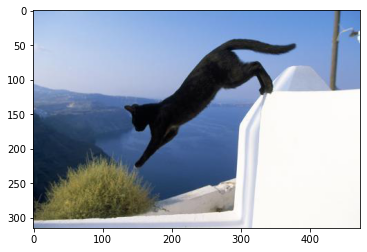

yes      <- is there a cat in the picture
yes      <- is this a picture of a cat
dog      <- is the animal in the picture a cat or a dog
brown    <- what color is the cat
green    <- what color are the cat's eyes
yes      <- is there an animal in the picture
dog      <- is the animal in the picture a cat or a fox
dog      <- is the animal in the picture a cat or a lion
blue     <- what color is the sea
green    <- what color is the grass
white    <- what color is the wall
brown    <- what color is the dog
65       <- what is the age of the universe?
yes      <- are dinosaurs still alive?


In [38]:
image_idx = 0

vqa(image_files[image_idx], [
    "is there a cat in the picture",
    "is this a picture of a cat",
    "is the animal in the picture a cat or a dog",
    "what color is the cat",
    "what color are the cat's eyes",
    "is there an animal in the picture",
    "is the animal in the picture a cat or a fox",
    "is the animal in the picture a cat or a lion",
    "what color is the sea",
    "what color is the grass",
    "what color is the wall",
    "what color is the dog",
    "what is the age of the universe?",
    "are dinosaurs still alive?",
])

## EXERCISE

Repeate the previous set of questions on all the images in the image_files list: what can you observe?
* Is there any general knowledge learnt (independent from the image given)
* What can you remark of the "out of context" questions
* How the image given affects the result

Add one new image of a snow-covered forrest and ask the same set of questions: what can you observe?

Add a question you would answer with one of the possibilites from answer_words: is this the returned one?